In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import copy
import geopandas as gpd  # Import geopandas
import fiona #공간데이터를 딕셔너리 형태 등으로 접근할 수 있는 라이브러리
import pyproj
from fiona.crs import from_epsg
from scipy import stats
import folium
from sklearn.model_selection import train_test_split


os.chdir('C:/Users/user/Desktop/서울시청/데이터/대여 데이터(종속변수)')
# 폰트 설정
mpl.rc('font', family=' Malgun Gothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

warnings.filterwarnings('ignore')

## 4월 대여 데이터(종속변수)

In [3]:
data_4=pd.read_csv('공공자전거 대여이력 정보_2020.04/공공자전거 대여이력 정보_2020.04.csv',encoding='cp949')

In [4]:
data_4.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-04779,2020-03-31 22:46:39,1722,창동청소년수련관,1,2020-04-01 00:00:00,01716,하나로마트 창동점,1,72.0,0.0
1,SPB-19055,2020-03-31 23:54:27,806,전자랜드 본관 앞,6,2020-04-01 00:00:11,00844,이촌2동 동원베네스트 아파트 앞,11,5.0,980.0
2,SPB-23457,2020-03-31 23:38:26,1352,e 편한세상 보문아파트 내,1,2020-04-01 00:00:11,00375,다산 어린이공원,4,22.0,2590.0
3,SPB-11094,2020-03-31 23:26:56,1355,보문2교,15,2020-04-01 00:00:12,01351,안암2교 옆,3,33.0,6750.0
4,SPB-22342,2020-03-31 23:57:22,2316,삼성역 8번출구,1,2020-04-01 00:00:13,02348,포스코사거리(기업은행),11,2.0,390.0


* 대여일시, 반납일시 datetime으로 변환,  대여소 번호 이상치 제거

In [5]:
data_4['count']=1

### 데이터 이상치 - 데이터 밀림 현상 제거

In [6]:
out=list(data_4[(data_4['이용거리'].isna()==True) & (data_4['반납일시'].apply(len)<10)]['반납일시'])
for i in out:
    data_4.loc[(data_4['반납일시']==i),['대여거치대','반납일시','반납대여소번호','반납대여소명','반납거치대','이용시간','이용거리']]=[0]+list(data_4[(data_4['반납일시']==i)].values[0][4:10])

### 대여소 번호 Type 변환, 고장 및 수거 함 제거

In [7]:
data_4['대여 대여소번호']=data_4['대여 대여소번호'].astype('int')
data_4['반납대여소번호']=data_4['반납대여소번호'].astype('int')
data_4=data_4[(data_4['대여 대여소번호']>=100) & (data_4['대여 대여소번호']<=4000)]
data_4=data_4[(data_4['반납대여소번호']>=100) & (data_4['반납대여소번호']<=4000)]

* 대여일시, 반납일시 datetime 변환

In [8]:
data_4_g=data_4.groupby('대여 대여소번호').sum()['count']
data_4['대여일시']=data_4['대여일시'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
data_4['반납일시']=data_4['반납일시'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

* 요일, 주말 컬럼 추가

In [9]:
data_4['이용시간']=data_4['반납일시']-data_4['대여일시']

In [10]:
data_4['대여일시(요일)']=data_4['대여일시'].apply(lambda x: x.weekday())
data_4['주말여부']=0
data_4.loc[(data_4['대여일시(요일)']>4), '주말여부']=1

* 국회의원 선거, 석가탄신일 주말 변경(공휴일)

In [11]:
data_4.loc[((data_4['대여일시'].apply(lambda x: x.day==15)) | (data_4['대여일시'].apply(lambda x: x.day==30))),'주말여부']=1

## 4월 평일, 주말 평균 이용량 계산

In [30]:
import calendar
def days(y,m):
    cal=calendar.monthrange(y,m)
    week=0
    holly=0
    for i in range(1,cal[1]+1):
        if datetime.datetime.strptime('{0}-{1}-{2}'.format(y,m,i),'%Y-%m-%d').weekday()<5:
            week+=1
        else:
            holly+=1
    return week, holly

In [12]:
week,holi=days(2020,4)
week=week-2
holi=holi+2
data_4_1=data_4.groupby(['대여 대여소번호', '주말여부']).sum()['count'].reset_index()
data_4_1.loc[(data_4_1['주말여부']==0),'count']=data_4_1.loc[(data_4_1['주말여부']==0),'count']/week
data_4_1.loc[(data_4_1['주말여부']==1),'count']=data_4_1.loc[(data_4_1['주말여부']==1),'count']/holi

In [13]:
data_4_1

,대여 대여소번호,주말여부,count
0,101,0,24.65
1,101,1,22.50
2,102,0,106.10
3,102,1,115.50
4,103,0,79.80
...,...,...,...
3319,3577,0,0.75
3320,3577,1,1.40
3321,3582,0,0.10
3322,3582,1,0.20


* 대여, 반납 시간 컬럼 추가

In [12]:
data_4['대여일시(시간)']=data_4['대여일시'].apply(lambda x: x.hour)

In [13]:
data_4['반납일시(시간)']=data_4['반납일시'].apply(lambda x: x.hour)

### 평일 시간대별 이용시간 분포

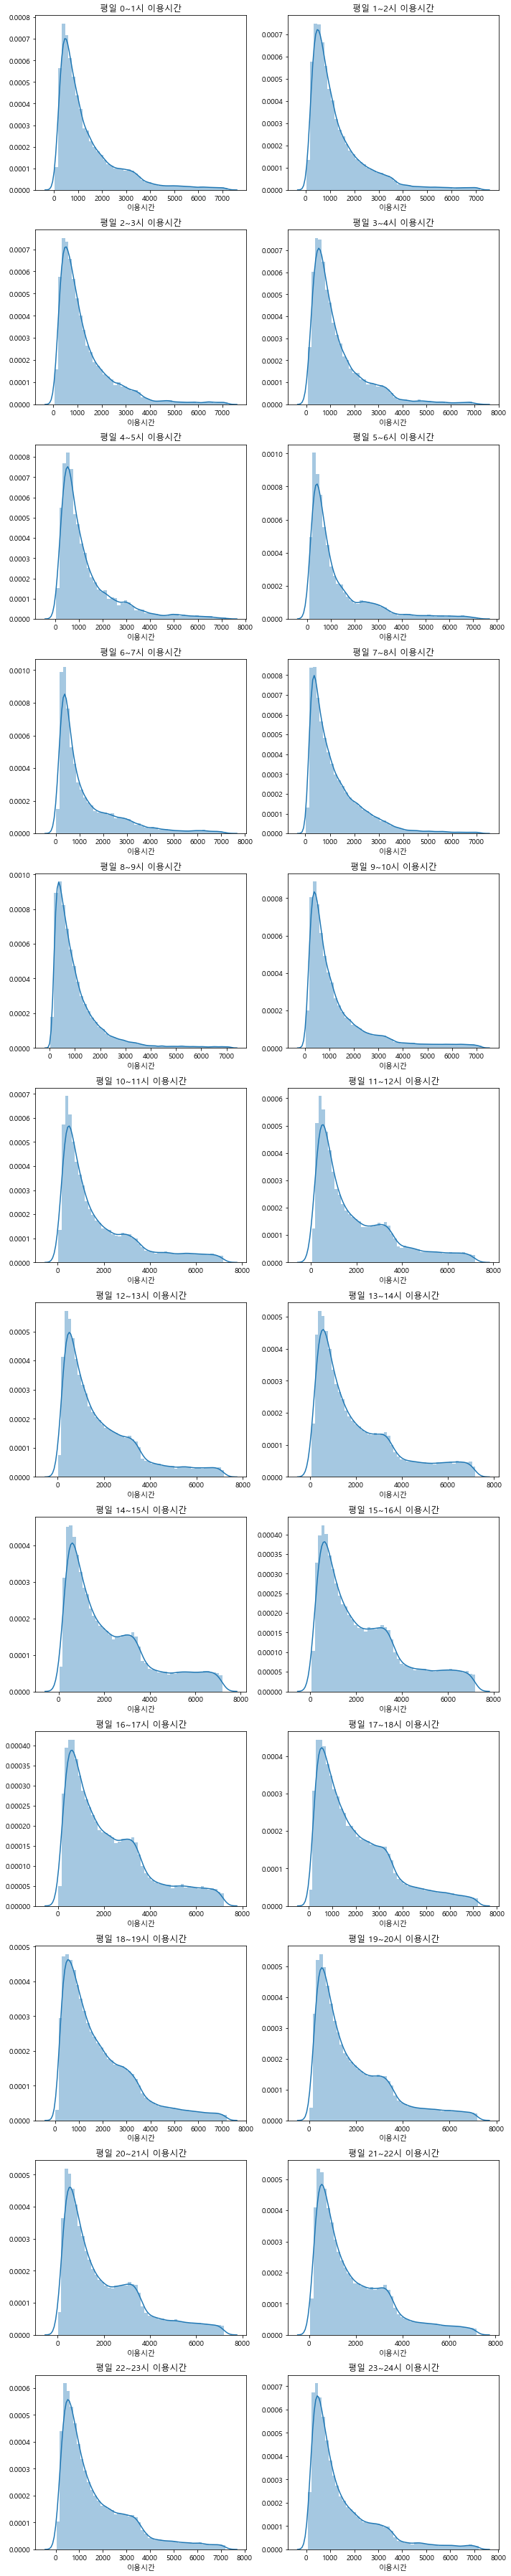

In [14]:
fig,axes=plt.subplots(nrows=12,ncols=2)
fig.set_size_inches(10,50)

for i in range(24):
    data_4_week=data_4[(data_4['주말여부']==0) & (data_4['대여일시(시간)']==i)]['이용시간']/datetime.timedelta(seconds=1)
    if i%2==0:
        t=0
    else:
        t=1
    sns.distplot(data_4_week[data_4_week<7200],ax=axes[i//2][t])
    axes[i//2][t].set_title('평일 {}~{}시 이용시간'.format(i,i+1,size=20))
plt.tight_layout()
plt.show()

### 주말 시간대별 이용시간 분포

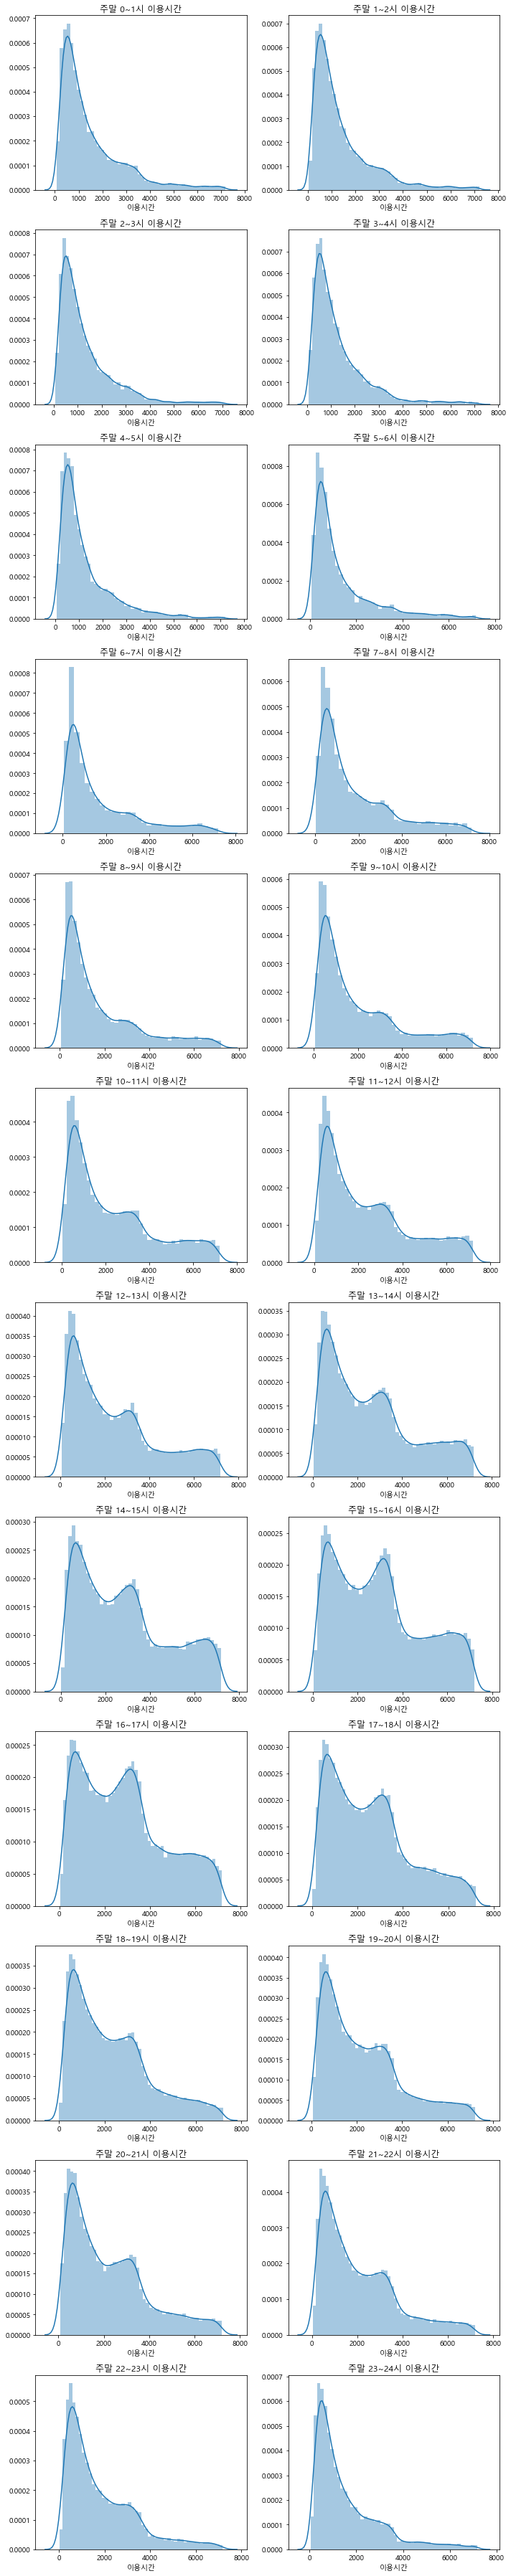

In [15]:
fig,axes=plt.subplots(nrows=12,ncols=2)
fig.set_size_inches(10,50)

for i in range(24):
    data_4_holi=data_4[(data_4['주말여부']==1) & (data_4['대여일시(시간)']==i)]['이용시간']/datetime.timedelta(seconds=1)
    if i%2==0:
        t=0
    else:
        t=1
    sns.distplot(data_4_holi[data_4_holi<7200],ax=axes[i//2][t])
    axes[i//2][t].set_title('주말 {}~{}시 이용시간'.format(i,i+1,size=20))
plt.tight_layout()
plt.show()

In [16]:
data_4_place=data_4.groupby(['주말여부','대여 대여소번호','반납대여소번호']).sum()['count'].reset_index()

In [17]:
data_4_place.head()

,주말여부,대여 대여소번호,반납대여소번호,count
0,0,101,101,61
1,0,101,102,7
2,0,101,103,7
3,0,101,104,34
4,0,101,105,5


## 가장 많이 대여가 일어나는 대여소 현황

In [18]:
data_4_place_week=data_4_place[data_4_place['주말여부']==0].sort_values(by=['대여 대여소번호','count'],ascending=[True, False])

In [19]:
data_4_place_holi=data_4_place[data_4_place['주말여부']==1].sort_values(by=['대여 대여소번호','count'],ascending=[True, False])

In [20]:
week_dup=data_4_place_week.drop_duplicates(['대여 대여소번호'],keep='first')
holi_dup=data_4_place_holi.drop_duplicates(['대여 대여소번호'],keep='first')

In [21]:
location=pd.read_csv('C:/Users/user/Desktop/서울시청/데이터/4월 이전 대여소.csv',encoding='cp949',index_col=0)

In [22]:
location=location[['대여소번호','위도','경도']]

In [23]:
location.head()

,대여소번호,위도,경도
1,2301,37.524071,127.021790
2,2302,37.505581,127.024277
3,2303,37.511517,127.021477
4,2304,37.512527,127.035835
5,2305,37.520641,127.034508


In [24]:
week_dup_m=week_dup.merge(location,left_on='대여 대여소번호',right_on='대여소번호')
week_dup_mer=week_dup_m.merge(location,left_on='반납대여소번호',right_on='대여소번호')

In [25]:
start=list(zip(week_dup_mer['위도_x'],week_dup_mer['경도_x']))
end=list(zip(week_dup_mer['위도_y'],week_dup_mer['경도_y']))

In [26]:
center = [37.541, 126.986]
m = folium.Map(location=center, zoom_start=10)
length=len(start)
for i in range(length):
    line=[start[i],end[i]]
    folium.PolyLine( locations = line, tooltip = 'PolyLine' ).add_to(m)
    folium.RegularPolygonMarker(location=end[i], fill_color='blue', number_of_sides=1, radius=0.5, rotation=3).add_to(m)
    
m

### 대여 기준

In [27]:
data_4_y=data_4[['대여 대여소번호','주말여부','대여일시(시간)','count']].groupby(['대여 대여소번호','주말여부','대여일시(시간)']).sum()

In [28]:
data_4_y.reset_index(inplace=True)

* 4월 평일, 주말 일 수

In [31]:
week_num,holi_num=days(2020,4)
week_num=week_num-2
holi_num=holi_num+2

* 06시 ~ 09시 대여

In [32]:
time0609=data_4_y[(data_4_y['대여일시(시간)']>=6) & (data_4_y['대여일시(시간)']<=8)]

* 18시 ~ 21시 대여

In [33]:
time1821=data_4_y[(data_4_y['대여일시(시간)']>=18) & (data_4_y['대여일시(시간)']<=20)]

In [34]:
time0609

,대여 대여소번호,주말여부,대여일시(시간),count
6,101,0,6,7
7,101,0,7,38
8,101,0,8,71
30,101,1,6,3
31,101,1,7,3
...,...,...,...,...
70954,3542,1,8,26
70973,3543,0,6,2
70974,3543,0,8,4
70994,3543,1,8,1


* 평일 기준 대여

In [35]:
week_0609=time0609.groupby(['대여 대여소번호','주말여부']).sum().reset_index()[['대여 대여소번호','주말여부','count']]

In [36]:
week_0609=week_0609[week_0609['주말여부']==0][['대여 대여소번호','count']]

In [37]:
week_1821=time1821.groupby(['대여 대여소번호','주말여부']).sum().reset_index()[['대여 대여소번호','주말여부','count']]

In [38]:
week_1821=week_1821[week_1821['주말여부']==0][['대여 대여소번호','count']]

In [39]:
week_0609['count']=week_0609['count']/week_num
week_1821['count']=week_1821['count']/week_num

* 주말 평균 이용량

In [40]:
holi_1=data_4_y[data_4_y['주말여부']==1]
holi_1=holi_1.groupby('대여 대여소번호').sum()['count'].reset_index()

In [41]:
holi_1['count']=holi_1['count']/holi_num
holi_1

,대여 대여소번호,count
0,101,22.5
1,102,115.5
2,103,93.1
3,104,75.0
4,105,45.4
...,...,...
1627,3566,0.1
1628,3571,0.3
1629,3575,1.0
1630,3577,1.4


### 반납 기준

In [42]:
data_4_y2=data_4[['반납대여소번호','주말여부','반납일시(시간)','count']].groupby(['반납대여소번호','주말여부','반납일시(시간)']).sum()

In [43]:
data_4_y2.reset_index(inplace=True)

In [44]:
data_4_y2

,반납대여소번호,주말여부,반납일시(시간),count
0,101,0,0,23
1,101,0,1,5
2,101,0,2,8
3,101,0,3,4
4,101,0,4,8
...,...,...,...,...
70511,3582,0,20,1
70512,3582,1,8,1
70513,3582,1,16,1
70514,3586,0,19,1


* 평일 06시 ~ 09시 반납

In [45]:
time0609_1=data_4_y2[(data_4_y2['반납일시(시간)']>=6) & (data_4_y2['반납일시(시간)']<=8)]

* 평일 18시 ~ 21시 반납

In [46]:
time1821_1=data_4_y2[(data_4_y2['반납일시(시간)']>=18) & (data_4_y2['반납일시(시간)']<=20)]

* 평일 기준 반납

In [47]:
week_0609_1=time0609_1.groupby(['반납대여소번호','주말여부']).sum().reset_index()[['반납대여소번호','주말여부','count']]
week_0609_1=week_0609_1[week_0609_1['주말여부']==0][['반납대여소번호','count']]

In [48]:
week_1821_1=time1821_1.groupby(['반납대여소번호','주말여부']).sum().reset_index()[['반납대여소번호','주말여부','count']]
week_1821_1=week_1821_1[week_1821_1['주말여부']==0][['반납대여소번호','count']]

In [49]:
week_0609_1['count']=week_0609_1['count']/week_num
week_1821_1['count']=week_1821_1['count']/week_num

* 주말 평균 반납

In [37]:
holi_2=data_4_y2[data_4_y['주말여부']==1]
holi_2=holi_2.groupby('반납대여소번호').sum()['count'].reset_index()

In [38]:
holi_2['count']=holi_2['count']/holi_num
holi_2

,반납대여소번호,count
0,101,22.3
1,102,121.0
2,103,96.0
3,104,76.7
4,105,47.6
...,...,...
1643,3543,17.9
1644,3575,1.6
1645,3576,0.2
1646,3577,0.8


### 시간대별 이용량 추이

In [50]:
data_4_hour=data_4.groupby(['주말여부','대여일시(시간)']).sum()['count'].reset_index()

In [52]:
week_count=pd.DataFrame(data_4_hour[data_4_hour['주말여부']==0]['count']/week_num).reset_index(drop=True)
holi_count=pd.DataFrame(data_4_hour[data_4_hour['주말여부']==1]['count']/holi_num).reset_index(drop=True)

In [53]:
week_holi=pd.concat([week_count,holi_count],axis=1)
week_holi.columns=['week','holi']

In [54]:
week_holi.head()

,week,holi
0,1601.00,2022.9
1,1186.75,1569.0
2,778.65,1140.9
3,536.40,804.0
4,364.85,484.3


<Figure size 432x288 with 0 Axes>

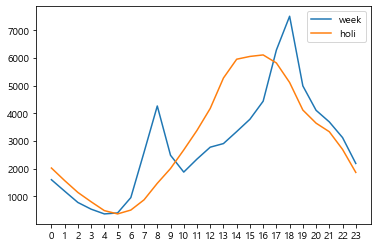

In [55]:
plt.figure()
week_holi.plot()
plt.xticks(np.arange(0, 24))
plt.show()

# 4월 대여소별 총 대여량
* 종속변수 생성

In [66]:
y=data_4.groupby('대여 대여소번호').sum()['count'].reset_index()

In [67]:
y=location.merge(y,left_on='대여소번호',right_on='대여 대여소번호',how='left')

In [69]:
y=y[['대여소번호','count']]

In [70]:
y.head()

,대여소번호,count
0,2301,4615.0
1,2302,1653.0
2,2303,891.0
3,2304,347.0
4,2305,508.0


In [71]:
y.to_csv('C:/Users/user/Desktop/서울시청/데이터/대여 데이터(종속변수)/4월대여량.csv',encoding='cp949',index=False)